Initialise the notebook:

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table

import os
import sys
sys.path.append('/Users/amsys/bindata')
import tfpy

from IPython.display import Image

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

os.chdir('/Users/amsys/paper_cloudy')

We've done two runs in the Ha range: one with a radius 10x our NGC5548 model.
Comparing the spectra for them:

/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


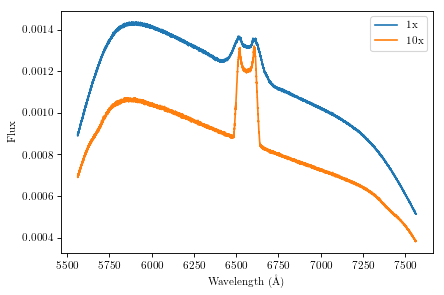

In [2]:
def plot_spec(col, spectra, names, logX=False, logY=False, scale_to=None, limX=False):
    fig, ax = plt.subplots()
    ax.set_xlabel(r"Wavelength (\AA)")
    
    if scale_to:
        ax.set_ylabel(r"$F_{\lambda}/F_{"+str(scale_to)+r"\AA}$")
    else:
        ax.set_ylabel(r"Flux")
        scale_factor = 1
    
    maxY = -1
    minY = 99999999
    
    for spectrum, name in zip(spectra, names):
        if scale_to: 
            # Annoyingly, the file is sorted by frequency not wavelength 
            # so we need to flip it to get searchsorted to run
            index_scale = np.searchsorted(spectrum['Lambda'][::-1], scale_to)
            scale_factor = spectrum[col][::-1][index_scale]
        
        if limX:
            minY_curr = np.amin(spectrum[col][(spectrum['Lambda']>limX[0]) & (spectrum['Lambda']<limX[1])])/scale_factor
            if minY_curr < minY:
                minY = minY_curr
            maxY_curr = np.amax(spectrum[col][(spectrum['Lambda']>limX[0]) & (spectrum['Lambda']<limX[1])])/scale_factor
            if maxY_curr > maxY:
                maxY = maxY_curr
        
        if logX and logY:
            ax.loglog(spectrum['Lambda'], spectrum[col]/scale_factor, label=name)
        elif logY:
            ax.semilogy(spectrum['Lambda'], spectrum[col]/scale_factor, label=name)
        elif logX:
            ax.semilogx(spectrum['Lambda'], spectrum[col]/scale_factor, label=name)
        else:
            ax.plot(spectrum['Lambda'], spectrum[col]/scale_factor, label=name)
            
    if limX:
        ax.set_xlim(limX[0], limX[1])
        ax.set_ylim(minY, maxY)
            
    ax.legend()
    fig.show()
    
spec_r01 = Table.read('r01/l100.spec', format='ascii')
spec_r10 = Table.read('r10/l100.spec', format='ascii')

plot_spec('A40P0.50', [spec_r01, spec_r10], ['1x', '10x'])

We get a **much** stronger line in the 10x radius model, with a vastly improved line-continuum ratio. The dips at the edge of the spectrum are a feature of our binning in the model; we have no photons generated beyond the <5500/>7500 bounds, so none can be up/down scattered from there into our spectrum.

Plotting the distribution of C-IV and H-I species throughout the wind:

In [17]:
import matplotlib.colors as colors

def load_grid(filename):
    return [np.loadtxt(filename+'grid_x.txt'),
            np.loadtxt(filename+'grid_z.txt')]

def plot_dat(table, grid_x, grid_z, title, label, volume=True):
    fig, ax = plt.subplots() 
    fig.suptitle(title)
    ax.set_xlabel('Log X (cm)')
    ax.set_ylabel('Log Z (cm)')
    
    size = (len(grid_x)-1, len(grid_z)-1)
    data = np.reshape(table['var'], size)
    if volume:
        for xi in range(size[0]):
            for zi in range(size[1]):
                # We need to correct the per-area emission to a per-volume emission
                area = 2. * 2. * np.pi * (grid_x[xi+1]-grid_x[xi]) * (grid_z[zi+1]-grid_z[zi])
                area += 2. * np.pi * grid_x[xi+1] * (grid_z[zi+1]-grid_z[zi])
                area += 2. * np.pi * grid_x[xi]   * (grid_z[zi+1]-grid_z[zi])
                if area > 0:
                    data[xi, zi] = data[xi, zi] / area
                
    im = ax.pcolormesh(np.log10(grid_x), np.log10(grid_z), np.ma.log10(data.T))
    ax.set_xlim(14.5, 18)
    ax.set_ylim(13, 17)
    cbar = fig.colorbar(im, ax=ax).set_label(label)
    fig.show()
    

/Users/amsys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


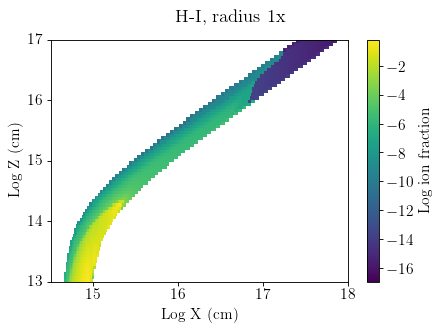

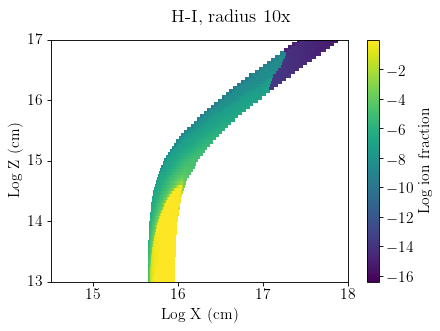

In [18]:
x_r01, z_r01 = load_grid('r01/')
x_r10, z_r10 = load_grid('r10/')

table_h1_r01 = Table.read('r01/l100.ionH1.dat', format='ascii')
table_h1_r10 = Table.read('r10/l100.ionH1.dat', format='ascii')

plot_dat(table_h1_r01, x_r01, z_r01, 'H-I, radius 1x', 'Log ion fraction', volume=False)
plot_dat(table_h1_r10, x_r10, z_r10, 'H-I, radius 10x', 'Log ion fraction', volume=False)

Neatly, we don't seem to see any change in the extended wind behaviour- everything at or greater than ~1e14.5cm height is more or less equivalent. The transition zone from wind base to extended wind is roughly consistent. We also see a much greater ion fraction of H-1 in the base.

/Users/amsys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


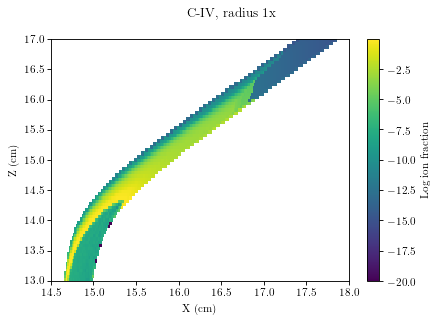

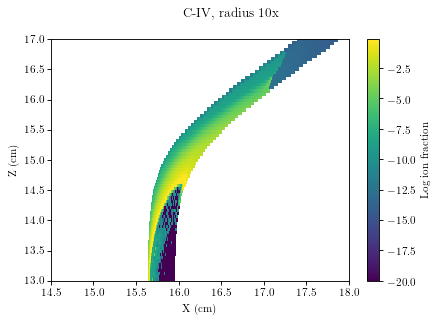

In [38]:
table_c4_r01 = Table.read('r01/l100.ionC4.dat', format='ascii')
table_c4_r10 = Table.read('r10/l100.ionC4.dat', format='ascii')

plot_dat(table_c4_r01, x_r01, z_r01, 'C-IV, radius 1x', 'Log ion fraction', volume=False)
plot_dat(table_c4_r10, x_r10, z_r10, 'C-IV, radius 10x', 'Log ion fraction', volume=False)

For C-IV, the situation is more or less the same in terms of ion distribution. Emission still occurs at roughly the same height above the disk, just at a later radius, the extended wind region is still roughly similar and peters out at the same radius. There's less C-IV in the base but the front seems sharper to compensate.

Next steps are:
* Do another run with a full spectrum to see if the line-continuum improvements are just a Ha thing and the rest of the spectrum is wrecked, or if it's an all-round good thing
* Bin the Hb photons and verify that we're expecting an OOM increase in path
* Do all this sort of analysis in Jupyter Notebooks stored on GitHub in future so I don't have to root around three different machines for the python & gnuplot scripts used to make figures

We want to compare the full spectra:
    

/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


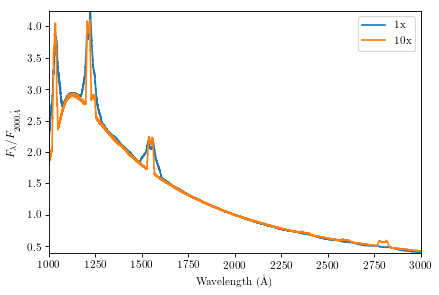

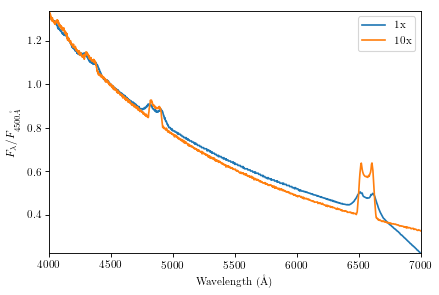

In [11]:
spec_r01_full = Table.read('r01/l100_f.spec', format='ascii')
spec_r10_full = Table.read('r10/l100_f.spec', format='ascii')
plot_spec('A40P0.50', [spec_r01_full, spec_r10_full], ['1x', '10x'], limX=(1000, 3000), scale_to=2000)
plot_spec('A40P0.50', [spec_r01_full, spec_r10_full], ['1x', '10x'], limX=(4000, 7000), scale_to=4500)

Looks fairly promising. The lower-wavelength lines aren't quite as boosted by the change as Ha is, but we get an improvement in Hb too. The lines are unsurprisingly narrowed, C-IV being most dramatically so. We want the actual delay too:

Running...
Opening database 'r10/l100'...
Found existing filled photon database 'r10/l100'
Opened DB
Created TF
'r10/ef_ha' successfully run (32.7s)
Plotting to file 'r10/ef_ha.eps'...
Total line: 5.915e-04
Successfully plotted (1.6s)
Plotted TF
Delay: 2.2508961489291295 days
Delay: 194476.99163901553 seconds


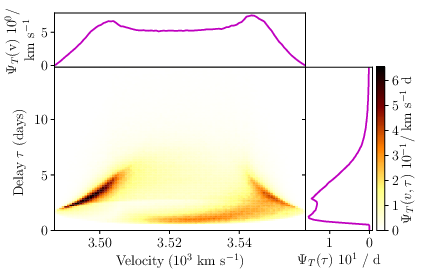

In [15]:
print('Running...')
db = tfpy.open_database('r10/l100')
print('Opened DB')
tf = tfpy.TransferFunction(db, 'r10/ef_ha', continuum=1.043e44, wave_bins=100, delay_bins=100)
print('Created TF')
tf.line(28, 6562.8).delay_dynamic_range(2).spectrum(0).run(scaling_factor=1/20).plot(velocity=True)
print('Plotted TF')
print("Delay: {} days".format(tf.delay(threshold=0.8) * 1.15741e-5))
print("Delay: {} seconds".format(tf.delay(threshold=0.8)))    
os.system('convert r10/ef_ha.eps r10/ef_ha.png')
Image(filename = 'r10/ef_ha.png', width=800, height=800)

The Ha delay is now muuuuch closer to the literature value for Hb. There's currently a run on to get the  C-IV photons, for binning and comparison to the data. Adding the point to our existing plot gives:

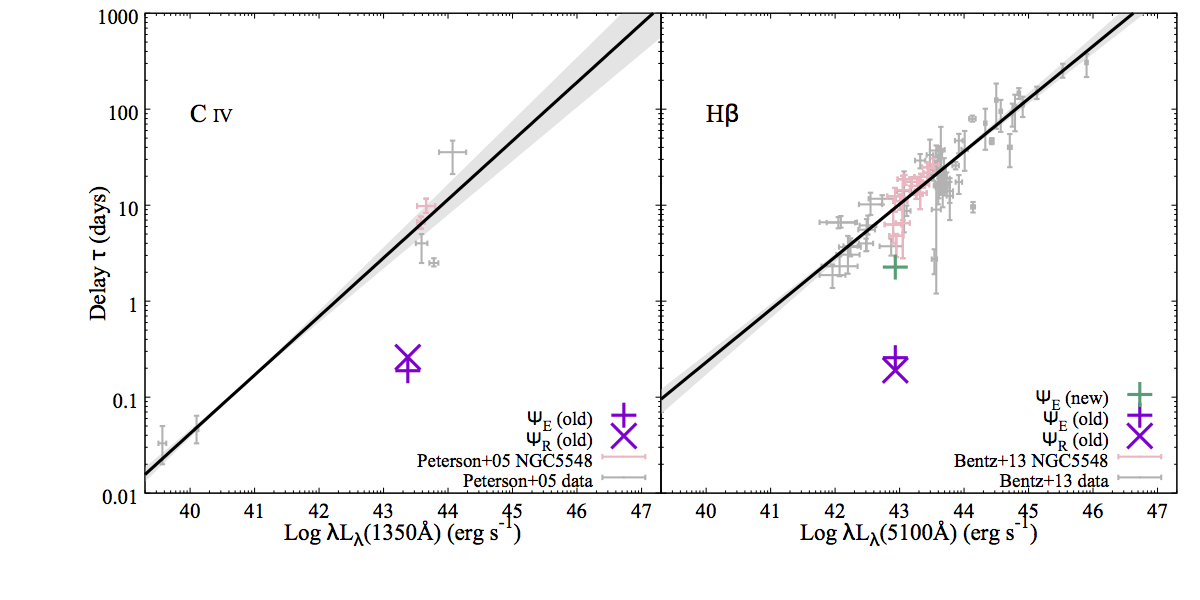

In [17]:
PATH = "/Users/amsys/paper_cloudy/lum_t.png"
Image(filename = PATH, width=800, height=800)

This still looks like we're on the very low end of the range, but it's a dramatic improvement!

I've downloaded some spectra for 5548 from Peterson's library here:
http://www.astronomy.ohio-state.edu/~agnwatch/n5548/
Playing with them but need to look for some modern ones.


/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


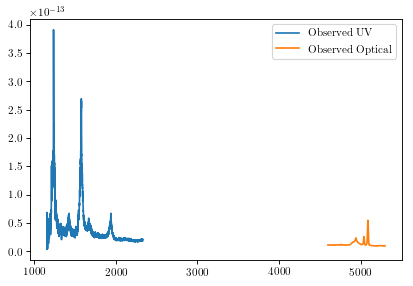

In [10]:
from astropy.io import fits
from astropy import table as apt

spec_obs_opt = Table.read('spectra_JD7517_optical.dat', format='ascii', names=('wave', 'val', 'error'))

fits_uv = fits.open('spectra_JD7517_uv.fits')
spec_obs_uv = fits_uv[0].data

spec_obs_uv = Table.read('spectra_JD49117_uv.lis', format='ascii', names=('wave', 'val', 'error'))

fig, ax = plt.subplots()
ax.plot(spec_obs_uv['wave'], spec_obs_uv['val'], '-', label='Observed UV')
ax.plot(spec_obs_opt['wave'], spec_obs_opt['val'], '-', label='Observed Optical')
legend = ax.legend()
fig.show()

# WIP: Playing around with spectra. These are obviously *not* concurrent observations

### 14-4-2018 BOTH LINES

I've run for both C-IV and Ha:

In [5]:
def tf_for_line(db, name, continuum, line, wave, scaling, spectrum=0, template=None):
    print('Running '+name)
    if template is None:
        tf = tfpy.TransferFunction(db, name, continuum=continuum, wave_bins=100, delay_bins=100)
    else:
        tf = tfpy.TransferFunction(db, name, continuum=continuum, template=template)
        
    tf.spectrum(spectrum).line(line, wave).delay_dynamic_range(2).run(scaling_factor=scaling)
    tf.plot(velocity=True)
    print("Delay: {} days".format(tf.delay(threshold=0.8) * 1.15741e-5))
    print("Delay: {} seconds".format(tf.delay(threshold=0.8)))
    return tf

In [20]:
db = tfpy.open_database('r10/l100')        
tf_l100_ha = tf_for_line(db, 'r10/ef_ha', 1.043e44, 28, 6562.8, 1/40, 0)
tf_l100_c4 = tf_for_line(db, 'r10/ef_c4', 1.043e44, 416, 1550, 1/40, 0)

Opening database 'r10/l100'...
Found existing filled photon database 'r10/l100'
Running r10/ef_ha
'r10/ef_ha' successfully run (32.6s)
Plotting to file 'r10/ef_ha.eps'...
Total line: 2.958e-04
Successfully plotted (1.5s)
Delay: 2.2508961489291295 days
Delay: 194476.99163901553 seconds
Running r10/ef_c4
'r10/ef_c4' successfully run (56.3s)
Plotting to file 'r10/ef_c4.eps'...
Total line: 4.692e-04
Successfully plotted (1.5s)
Delay: 2.7488834723 days
Delay: 237503.0 seconds


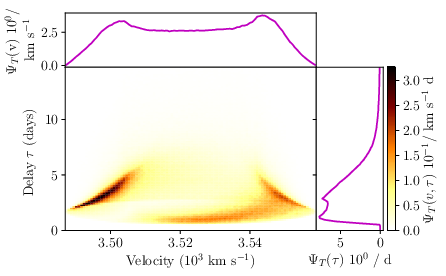

In [18]:
os.system('convert r10/ef_ha.eps r10/ef_ha.png')
Image(filename = 'r10/ef_ha.png', width=800, height=800)

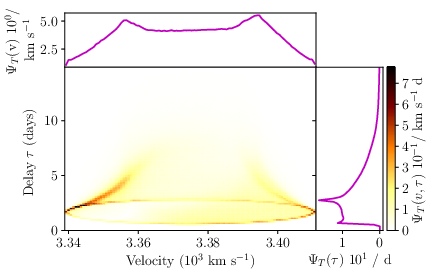

In [19]:
os.system('convert r10/ef_c4.eps r10/ef_c4.png')
Image(filename = 'r10/ef_c4.png', width=800, height=800)

We see a pretty dramatic difference in the C4 and Ha emissivity functions, now- the C4 is *much* more limited radius, at a notably higher velocity, and has a bigger difference in delay. The outflow character is basically illegible, though...

Updating our EF delay plot, we get a C-IV delay that looks good too. It suggests that our model is at least roughly matching *one* of the states NGC5548 occupies. 
![EF_delays](lum_t.png)

I'm now doing runs to get the RF delays. As we can see from the plot, we'd expect the RF delays to be longer than the EF delays for C-IV... unfortunately, the breathing BLR effect may result in things going the **other** way for Hb, and it's already a bit marginal. I'll try and plot the Hb emissivity cross-section of the wind to see if we're going to get the same effect.

Currently, what's needed are some nice broad NGC5548 spectra to compare to. I'm playing around with the http://www.astronomy.ohio-state.edu/~agnwatch/n5548/ ones as they're easy to get to but should probably hunt down a paper with some more modern ones in.

In [15]:
def load_grid(filename):
    return [np.loadtxt(filename+'grid_x.txt'),
            np.loadtxt(filename+'grid_z.txt')]

x_r01, z_r01 = load_grid('r01/')
x_r10, z_r10 = load_grid('r10/')

table_line_hb_r01 = Table.read('r01/l100.lineH1.4-2.dat', format='ascii')
table_line_hb_r10 = Table.read('r10/l100.lineH1.4-2.dat', format='ascii')
table_line_c4_r01 = Table.read('r01/l100.lineC4.dat', format='ascii')
table_line_c4_r10 = Table.read('r10/l100.lineC4.dat', format='ascii')

# x_old, z_old = load_grid('wind_')
# c4_old = Table.read('sey_100.lineC4.dat', format='ascii')
# plot_dat(c4_old, x_old, z_old, r'C-IV OLD', r'Log L_{line} (erg s^{-1} cm^{-3})')

plot_dat(table_line_c4_r01, x_r01, z_r01, r'C-IV, radius 1x', r'Log L_{line} (erg s^{-1} cm^{-3})')
plot_dat(table_line_c4_r10, x_r10, z_r10, r'C-IV, radius 10x', r'Log L_{line} (erg s^{-1} cm^{-3})')
plot_dat(table_line_hb_r01, x_r01, z_r01, r'H$\beta$, radius 1x', r'Log L_{line} (erg s^{-1} cm^{-3})')
plot_dat(table_line_hb_r10, x_r10, z_r10, r'H$\beta$, radius 10x', r'Log L_{line} (erg s^{-1} cm^{-3})')

NameError: name 'plot_dat' is not defined

The emissivity cross-sections are a little weird! For Hb It looks like there's two fronts; one corresponding to emission from the disk, one corresponding to emission from the central source. We should probably rerun everything with Hb now we know that Hb emission in this model is high enough that it's not a waste of time to run it.

### 27-4-2018 BOTH LINES

Now we've got the data to do response functions!

In [3]:
def response_map(tf_min, tf_mid, tf_max):
    tf_mid.response_map_by_tf(tf_min, tf_max).plot(response_map=True, name='rf')
    print("Delay: {} days".format(tf_mid.delay(threshold=0.8, response=True) * 1.15741e-5))
    print("Delay: {} seconds".format(tf_mid.delay(threshold=0.8, response=True)))

In [36]:
db = tfpy.open_database('r10/l110')        
tf_l110_ha = tf_for_line(db, 'r10/l110_ef_ha', 1.043e44*1.1, 28, 6562.8, 1/40, 0, template=tf_l100_ha)
tf_l110_c4 = tf_for_line(db, 'r10/l110_ef_c4', 1.043e44*1.1, 416, 1550, 1/40, 0, template=tf_l100_c4)
db = tfpy.open_database('r10/l090')        
tf_l090_ha = tf_for_line(db, 'r10/l090_ef_ha', 1.043e44*0.9, 28, 6562.8, 1/40, 0, template=tf_l100_ha)
tf_l090_c4 = tf_for_line(db, 'r10/l090_ef_c4', 1.043e44*0.9, 416, 1550, 1/40, 0, template=tf_l100_c4)

response_map(tf_l090_ha, tf_l100_ha, tf_l110_ha)
response_map(tf_l090_c4, tf_l100_c4, tf_l110_c4)

Opening database 'r10/l110'...
Found existing filled photon database 'r10/l110'
Running r10/l110_ef_ha
Templating 'r10/l110_ef_ha' off of 'r10/ef_ha'...
'r10/l110_ef_ha' successfully run (30.3s)
Plotting to file 'r10/l110_ef_ha.eps'...
Total line: 2.733e-04
Successfully plotted (1.5s)
Delay: 2.1822236834972886 days
Delay: 188543.70391626898 seconds
Running r10/l110_ef_c4
Templating 'r10/l110_ef_c4' off of 'r10/ef_c4'...
'r10/l110_ef_c4' successfully run (52.2s)
Plotting to file 'r10/l110_ef_c4.eps'...
Total line: 4.404e-04
Successfully plotted (1.5s)
Delay: 2.7488834723 days
Delay: 237503.00000000003 seconds
Opening database 'r10/l090'...
Found existing filled photon database 'r10/l090'
Running r10/l090_ef_ha
Templating 'r10/l090_ef_ha' off of 'r10/ef_ha'...
'r10/l090_ef_ha' successfully run (33.8s)
Plotting to file 'r10/l090_ef_ha.eps'...
Total line: 3.194e-04
Successfully plotted (1.5s)
Delay: 2.253737078780556 days
Delay: 194722.44742835782 seconds
Running r10/l090_ef_c4
Templating 

Unfortunately, when we put the response delays on this gives us *shorter* delays. This is a shame. This plot is mislabelled! I ran Ha, as we weren't sure whether the Hb line would be strong enough to give us a good RF with few photons. That's definitely the case now, so I'm redoing it with Hb to be sure.
![EF_delays](lum_t.png)

# 13-5-18 30x radius
Now we can repeat the analysis for Hb on a 30x radius.

In [9]:
db = tfpy.open_database('r30/l100')        
tf_r30_l100_hb = tf_for_line(db, 'r30/l100_ef_hb', 1.043e44, 31, 4861.3, 1/30, 0)
tf_r30_l100_c4 = tf_for_line(db, 'r30/l100_ef_c4', 1.043e44, 416, 1550, 1/30, 0)
db = tfpy.open_database('r30/l110')        
tf_r30_l110_hb = tf_for_line(db, 'r30/l110_ef_hb', 1.043e44*1.1, 31, 4861.3, 1/30, 0, template=tf_r30_l100_hb)
tf_r30_l110_c4 = tf_for_line(db, 'r30/l110_ef_c4', 1.043e44*1.1, 416, 1550, 1/30, 0, template=tf_r30_l100_c4)
db = tfpy.open_database('r30/l090')        
tf_r30_l090_hb = tf_for_line(db, 'r30/l090_ef_hb', 1.043e44*0.9, 31, 4861.3, 1/30, 0, template=tf_r30_l100_hb)
tf_r30_l090_c4 = tf_for_line(db, 'r30/l090_ef_c4', 1.043e44*0.9, 416, 1550, 1/30, 0, template=tf_r30_l100_c4)

response_map(tf_r30_l090_hb, tf_r30_l100_hb, tf_r30_l110_hb)
response_map(tf_r30_l090_c4, tf_r30_l100_c4, tf_r30_l110_c4)

Opening database 'r30/l100'...
Found existing filled photon database 'r30/l100'
Running r30/l100_ef_hb
'r30/l100_ef_hb' successfully run (4.2s)
Plotting to file 'r30/l100_ef_hb.eps'...
Total line: 6.242e-05
Successfully plotted (1.5s)
Delay: 2.5503073407215715 days
Delay: 220346.06066316788 seconds
Running r30/l100_ef_c4
'r30/l100_ef_c4' successfully run (24.2s)
Plotting to file 'r30/l100_ef_c4.eps'...
Total line: 3.930e-04
Successfully plotted (1.5s)
Delay: 4.605165040169431 days
Delay: 397885.36820741405 seconds
Opening database 'r30/l110'...
Found existing filled photon database 'r30/l110'
Running r30/l110_ef_hb
Templating 'r30/l110_ef_hb' off of 'r30/l100_ef_hb'...
'r30/l110_ef_hb' successfully run (4.7s)
Plotting to file 'r30/l110_ef_hb.eps'...
Total line: 6.186e-05
Successfully plotted (1.5s)
Delay: 2.5536616254558773 days
Delay: 220635.8702150385 seconds
Running r30/l110_ef_c4
Templating 'r30/l110_ef_c4' off of 'r30/l100_ef_c4'...
'r30/l110_ef_c4' successfully run (23.0s)
Plotti

Let's also correct the Ha to Hb:

In [11]:
db = tfpy.open_database('r10hb/l100')        
tf_r10_l100_hb = tf_for_line(db, 'r10/l100_ef_hb', 1.043e44, 31, 4861.3, 1/30, 0)
tf_r10_l100_c4 = tf_for_line(db, 'r10/l100_ef_c4', 1.043e44, 416, 1550, 1/30, 0)
db = tfpy.open_database('r10hb/l110')        
tf_r10_l110_hb = tf_for_line(db, 'r10/l110_ef_hb', 1.043e44*1.1, 31, 4861.3, 1/30, 0, template=tf_r10_l100_hb)
tf_r10_l110_c4 = tf_for_line(db, 'r10/l110_ef_c4', 1.043e44*1.1, 416, 1550, 1/30, 0, template=tf_r10_l100_c4)
db = tfpy.open_database('r10hb/l090')        
tf_r10_l090_hb = tf_for_line(db, 'r10/l090_ef_hb', 1.043e44*0.9, 31, 4861.3, 1/30, 0, template=tf_r10_l100_hb)
tf_r10_l090_c4 = tf_for_line(db, 'r10/l090_ef_c4', 1.043e44*0.9, 416, 1550, 1/30, 0, template=tf_r10_l100_c4)

response_map(tf_r10_l090_hb, tf_r10_l100_hb, tf_r10_l110_hb)
response_map(tf_r10_l090_c4, tf_r10_l100_c4, tf_r10_l110_c4)

Opening database 'r10hb/l100'...
Found existing filled photon database 'r10hb/l100'
Running r10/l100_ef_hb
'r10/l100_ef_hb' successfully run (8.6s)
Plotting to file 'r10/l100_ef_hb.eps'...
Total line: 1.136e-04
Successfully plotted (1.6s)
Delay: 2.0186634124268963 days
Delay: 174412.12815051677 seconds
Running r10/l100_ef_c4
'r10/l100_ef_c4' successfully run (41.9s)
Plotting to file 'r10/l100_ef_c4.eps'...
Total line: 6.252e-04
Successfully plotted (1.6s)
Delay: 2.7463140221 days
Delay: 237281.0 seconds
Opening database 'r10hb/l110'...
Found existing filled photon database 'r10hb/l110'
Running r10/l110_ef_hb
Templating 'r10/l110_ef_hb' off of 'r10/l100_ef_hb'...
'r10/l110_ef_hb' successfully run (8.6s)
Plotting to file 'r10/l110_ef_hb.eps'...
Total line: 1.103e-04
Successfully plotted (1.6s)
Delay: 2.0858542607382837 days
Delay: 180217.40444080177 seconds
Running r10/l110_ef_c4
Templating 'r10/l110_ef_c4' off of 'r10/l100_ef_c4'...
'r10/l110_ef_c4' successfully run (42.3s)
Plotting to 

/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


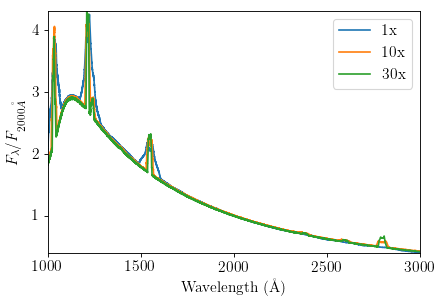

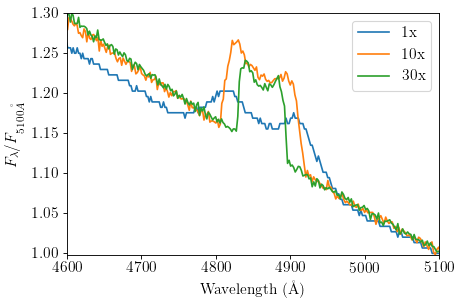

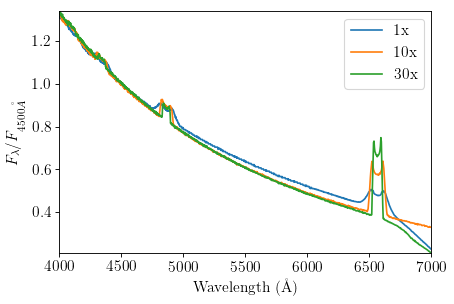

In [14]:
spec_r01_full = Table.read('r01/l100_f.spec', format='ascii')
spec_r10_full = Table.read('r10/l100_f.spec', format='ascii')
spec_r30_full = Table.read('r30/l100.spec', format='ascii')
plot_spec('A40P0.50', [spec_r01_full, spec_r10_full, spec_r30_full], ['1x', '10x', '30x'], limX=(1000, 3000), scale_to=2000)
plot_spec('A40P0.50', [spec_r01_full, spec_r10_full, spec_r30_full], ['1x', '10x', '30x'], limX=(4600, 5100), scale_to=5100)
plot_spec('A40P0.50', [spec_r01_full, spec_r10_full, spec_r30_full], ['1x', '10x', '30x'], limX=(4000, 7000), scale_to=4500)

Interesting: At 30 days, Hb flips! From RF delay lower than EF delay, to EF delay lower than RF delay! We get about the increase in radius we'd expect in C-IV, but Hb *doesn't* increase that much. It's only a factor of maybe ~50%, rather than the 3x we'd have liked. We also get a ~50% increase in Ha emission, as we can see above, but we actually see a *reduction* in Hb (though still dramatically more than our 1x radius). 
![EF_delays](lum_t.png)

/Users/amsys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


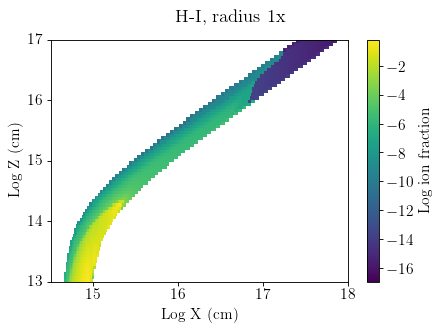

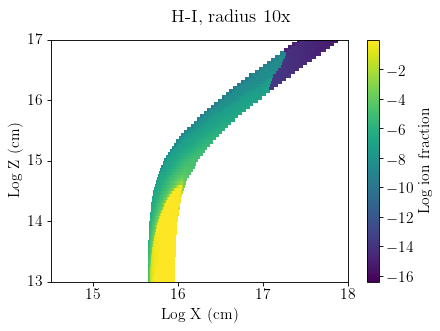

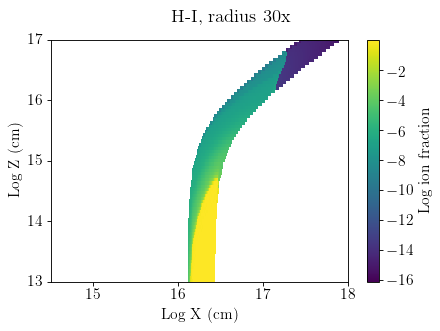

In [20]:
x_r01, z_r01 = load_grid('r01/')
x_r10, z_r10 = load_grid('r10/')
x_r30, z_r30 = load_grid('r30/')

table_h1_r01 = Table.read('r01/l100.ionH1.dat', format='ascii')
table_h1_r10 = Table.read('r10/l100.ionH1.dat', format='ascii')
table_h1_r30 = Table.read('r30/l100.ionH1.dat', format='ascii')

plot_dat(table_h1_r01, x_r01, z_r01, 'H-I, radius 1x', 'Log ion fraction', volume=False)
plot_dat(table_h1_r10, x_r10, z_r10, 'H-I, radius 10x', 'Log ion fraction', volume=False)
plot_dat(table_h1_r30, x_r30, z_r30, 'H-I, radius 30x', 'Log ion fraction', volume=False)

In [92]:
def plot_dat_many(tables, grids_x, grids_z, xlims, zlims, titles, title, label, shared_y=False, shared_cbar=False, volume=True):
    if shared_y:
        fig, axes = plt.subplots(1, len(tables), sharey='row')
    else:
        fig, axes = plt.subplots(1, len(tables))
        
    fig.suptitle(title, y=1.03)
    axes[0].set_ylabel('Log Z (cm)')
    images = []
    
    if shared_cbar:
        vmin = float('inf')
        vmax = -float('inf')
    
    for ax, table, grid_x, grid_z, xlim, zlim, title in zip(axes, tables, grids_x, grids_z, xlims, zlims, titles):
        ax.set_title(title)
        ax.set_xlabel('Log X (cm)')
    
        size = (len(grid_x)-1, len(grid_z)-1)
        data = np.reshape(table['var'], size)

        if volume:
            for xi in range(size[0]):
                for zi in range(size[1]):
                    # We need to correct the per-area emission to a per-volume emission
                    area = 2. * 2. * np.pi * (grid_x[xi+1]-grid_x[xi]) * (grid_z[zi+1]-grid_z[zi])
                    area += 2. * np.pi * grid_x[xi+1] * (grid_z[zi+1]-grid_z[zi])
                    area += 2. * np.pi * grid_x[xi]   * (grid_z[zi+1]-grid_z[zi])
                    if area > 0:
                        data[xi, zi] = data[xi, zi] / area

        if shared_cbar:
            if data.max() > vmax:
                vmax = data.max()
            if data.min() < vmin:
                vmin = data.min()
                        
        image = ax.pcolormesh(np.log10(grid_x), np.log10(grid_z), np.ma.log10(data.T))
        images.append(image)
        ax.set_xlim(xlim[0], xlim[1])
        ax.set_ylim(zlim[0], zlim[1])
    
    if not shared_cbar:
        for image, ax in zip(images, axes):
            cbar = fig.colorbar(image, ax=ax).set_label(label)
    else:
        for image, ax in zip(images, axes):
            image.clim = [vmin, vmax]
        
        cbar = fig.colorbar(images[-1], ax=axes[-1]).set_label(label)
            
    fig.tight_layout()
    if shared_y:
        fig.subplots_adjust(wspace=0)
    fig.show()
    

/Users/amsys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


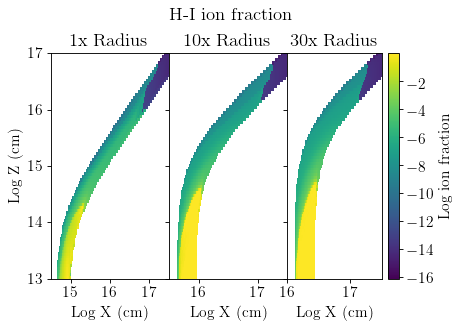

In [97]:
x_r01, z_r01 = load_grid('r01/')
x_r10, z_r10 = load_grid('r10/')
x_r30, z_r30 = load_grid('r30/')

table_h1_r01 = Table.read('r01/l100.ionH1.dat', format='ascii')
table_h1_r10 = Table.read('r10/l100.ionH1.dat', format='ascii')
table_h1_r30 = Table.read('r30/l100.ionH1.dat', format='ascii')

plot_dat_many([table_h1_r01, table_h1_r10, table_h1_r30],
              [x_r01, x_r10, x_r30], [z_r01, z_r10, z_r30],
              xlims=[(14.5, 17.5), (15.5, 17.5), (16, 17.5)],
              zlims=[(13, 17), (13, 17), (13, 17)],
              titles=['1x Radius', '10x Radius', '30x Radius'],
              title='H-I ion fraction', label='Log ion fraction', 
              shared_y=True, volume=False, shared_cbar=True)


/Users/amsys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


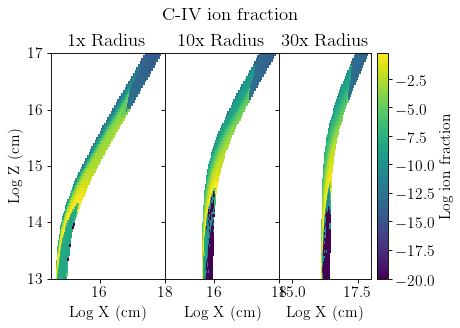

In [85]:
x_r01, z_r01 = load_grid('r01/')
x_r10, z_r10 = load_grid('r10/')
x_r30, z_r30 = load_grid('r30/')

table_h1_r01 = Table.read('r01/l100.ionC4.dat', format='ascii')
table_h1_r10 = Table.read('r10/l100.ionC4.dat', format='ascii')
table_h1_r30 = Table.read('r30/l100.ionC4.dat', format='ascii')

plot_dat_many([table_h1_r01, table_h1_r10, table_h1_r30],
              [x_r01, x_r10, x_r30], [z_r01, z_r10, z_r30],
              xlims=[(14.5, 17.5), (15.5, 17.5), (16, 17.5)],
              zlims=[(13, 17), (13, 17), (13, 17)],
              titles=['1x Radius', '10x Radius', '30x Radius'],
              title='C-IV ion fraction', label='Log ion fraction', 
              shared_y=True, volume=False, shared_cbar=True)

/Users/amsys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


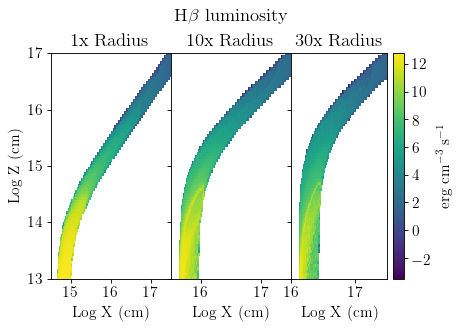

In [98]:
x_r01, z_r01 = load_grid('r01/')
x_r10, z_r10 = load_grid('r10/')
x_r30, z_r30 = load_grid('r30/')

table_hb_r01 = Table.read('r01/l100.lineH1.4-2.dat', format='ascii')
table_hb_r10 = Table.read('r10/l100.lineH1.4-2.dat', format='ascii')
table_hb_r30 = Table.read('r30/l100.lineH1.4-2.dat', format='ascii')

plot_dat_many([table_hb_r01, table_hb_r10, table_hb_r30],
              [x_r01, x_r10, x_r30], [z_r01, z_r10, z_r30],
              xlims=[(14.5, 17.5), (15.5, 17.5), (16, 17.5)],
              zlims=[(13, 17), (13, 17), (13, 17)],
              titles=['1x Radius', '10x Radius', '30x Radius'],
              title=r'H$\beta$ luminosity', label=r'erg cm$^{-3}$ s$^{-1}$', 
              shared_y=True, volume=True, shared_cbar=True)

/Users/amsys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


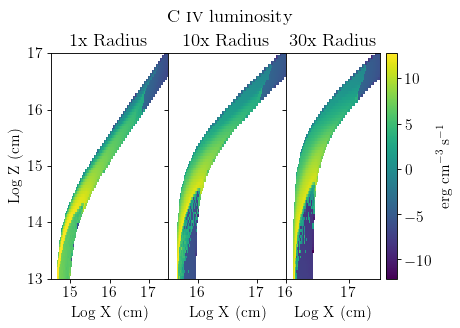

In [99]:
x_r01, z_r01 = load_grid('r01/')
x_r10, z_r10 = load_grid('r10/')
x_r30, z_r30 = load_grid('r30/')

table_hb_r01 = Table.read('r01/l100.lineC4.dat', format='ascii')
table_hb_r10 = Table.read('r10/l100.lineC4.dat', format='ascii')
table_hb_r30 = Table.read('r30/l100.lineC4.dat', format='ascii')

plot_dat_many([table_hb_r01, table_hb_r10, table_hb_r30],
              [x_r01, x_r10, x_r30], [z_r01, z_r10, z_r30],
              xlims=[(14.5, 17.5), (15.5, 17.5), (16, 17.5)],
              zlims=[(13, 17), (13, 17), (13, 17)],
              titles=['1x Radius', '10x Radius', '30x Radius'],
              title=r'C~\textsc{iv} luminosity', label=r'erg cm$^{-3}$ s$^{-1}$', 
              shared_y=True, volume=True, shared_cbar=True)